In [ ]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
import matplotlib.pyplot as plt


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device.type

'cuda'

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [ ]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [ ]:
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [ ]:
class AE(nn.Module):
  def __init__(self):
    super(AE,self).__init__()
    #Encoder
    self.encoder = nn.Sequential(
        nn.Linear(28*28, 256),
        nn.BatchNorm1d(256),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.2),

        nn.Linear(256, 128),
        nn.BatchNorm1d(128),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.2),

        nn.Linear(128, 64),
        nn.BatchNorm1d(64),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.2),

        nn.Linear(64, 10)
    )

    self.decoder = nn.Sequential(
        nn.Linear(10, 64),
        nn.BatchNorm1d(64),
        nn.LeakyReLU(0.2),

        nn.Linear(64, 128),
        nn.BatchNorm1d(128),
        nn.LeakyReLU(0.2),

        nn.Linear(128, 256),
        nn.BatchNorm1d(256),
        nn.LeakyReLU(0.2),

        nn.Linear(256, 28*28),
        nn.Sigmoid()
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [ ]:
ae_model = AE().to(device)
ae_optimizer = optim.Adam(ae_model.parameters(), lr=1e-3)
ae_loss_fn = nn.MSELoss()
ae_losses = []

In [ ]:
for epoch in range(20):
    total_loss = 0
    for data in train_loader:
        img, _ = data
        img = img.view(img.size(0), -1).to(device)

        reconstructed = ae_model(img)
        loss = ae_loss_fn(reconstructed, img)

        ae_optimizer.zero_grad()
        loss.backward()
        ae_optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    ae_losses.append(avg_loss)
    print(f"AE Epoch [{epoch+1}/20], Loss: {avg_loss:.4f}")

AE Epoch [1/20], Loss: 0.0385
AE Epoch [2/20], Loss: 0.0264
AE Epoch [3/20], Loss: 0.0247
AE Epoch [4/20], Loss: 0.0238
AE Epoch [5/20], Loss: 0.0231
AE Epoch [6/20], Loss: 0.0227
AE Epoch [7/20], Loss: 0.0224
AE Epoch [8/20], Loss: 0.0221
AE Epoch [9/20], Loss: 0.0218
AE Epoch [10/20], Loss: 0.0216
AE Epoch [11/20], Loss: 0.0215
AE Epoch [12/20], Loss: 0.0213
AE Epoch [13/20], Loss: 0.0211
AE Epoch [14/20], Loss: 0.0210
AE Epoch [15/20], Loss: 0.0209
AE Epoch [16/20], Loss: 0.0208
AE Epoch [17/20], Loss: 0.0206
AE Epoch [18/20], Loss: 0.0206
AE Epoch [19/20], Loss: 0.0205
AE Epoch [20/20], Loss: 0.0204


In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
        )

        self.fc_mu = nn.Linear(128, 10)
        self.fc_logvar = nn.Linear(128, 10)

        self.decoder = nn.Sequential(
            nn.Linear(10, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)

        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std

        decoded = self.decoder(z)
        return decoded, mu, logvar

In [ ]:
vae_model = VAE().to(device)
vae_optimizer = optim.Adam(vae_model.parameters(), lr=1e-3)
vae_losses = []

In [ ]:
for epoch in range(epochs):
    total_loss = 0
    for data in train_loader:
        img, _ = data
        img = img.view(img.size(0), -1).to(device)

        reconstructed, mu, logvar = vae_model(img)

        recon_loss = nn.functional.binary_cross_entropy(reconstructed, img, reduction='sum')
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon_loss + kl_loss

        vae_optimizer.zero_grad()
        loss.backward()
        vae_optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    vae_losses.append(avg_loss)
    print(f"VAE Epoch [{epoch+1}/20], Loss: {avg_loss:.4f}")

VAE Epoch [1/20], Loss: 23134.7430
VAE Epoch [2/20], Loss: 16677.1123
VAE Epoch [3/20], Loss: 15490.6977
VAE Epoch [4/20], Loss: 14958.9259
VAE Epoch [5/20], Loss: 14648.4568
VAE Epoch [6/20], Loss: 14440.8677
VAE Epoch [7/20], Loss: 14291.9331
VAE Epoch [8/20], Loss: 14168.5788
VAE Epoch [9/20], Loss: 14060.6291
VAE Epoch [10/20], Loss: 13976.3815
VAE Epoch [11/20], Loss: 13897.4590
VAE Epoch [12/20], Loss: 13822.2666
VAE Epoch [13/20], Loss: 13764.9965
VAE Epoch [14/20], Loss: 13707.6298
VAE Epoch [15/20], Loss: 13656.2678
VAE Epoch [16/20], Loss: 13607.5572
VAE Epoch [17/20], Loss: 13570.1552
VAE Epoch [18/20], Loss: 13530.7833
VAE Epoch [19/20], Loss: 13492.7418
VAE Epoch [20/20], Loss: 13460.2344


In [ ]:
ae_model.eval()
vae_model.eval()

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
  )
  (fc_mu): Linear(in_features=128, out_features=10, bias=True)
  (fc_logvar): Linear(in_features=128, out_features=10, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

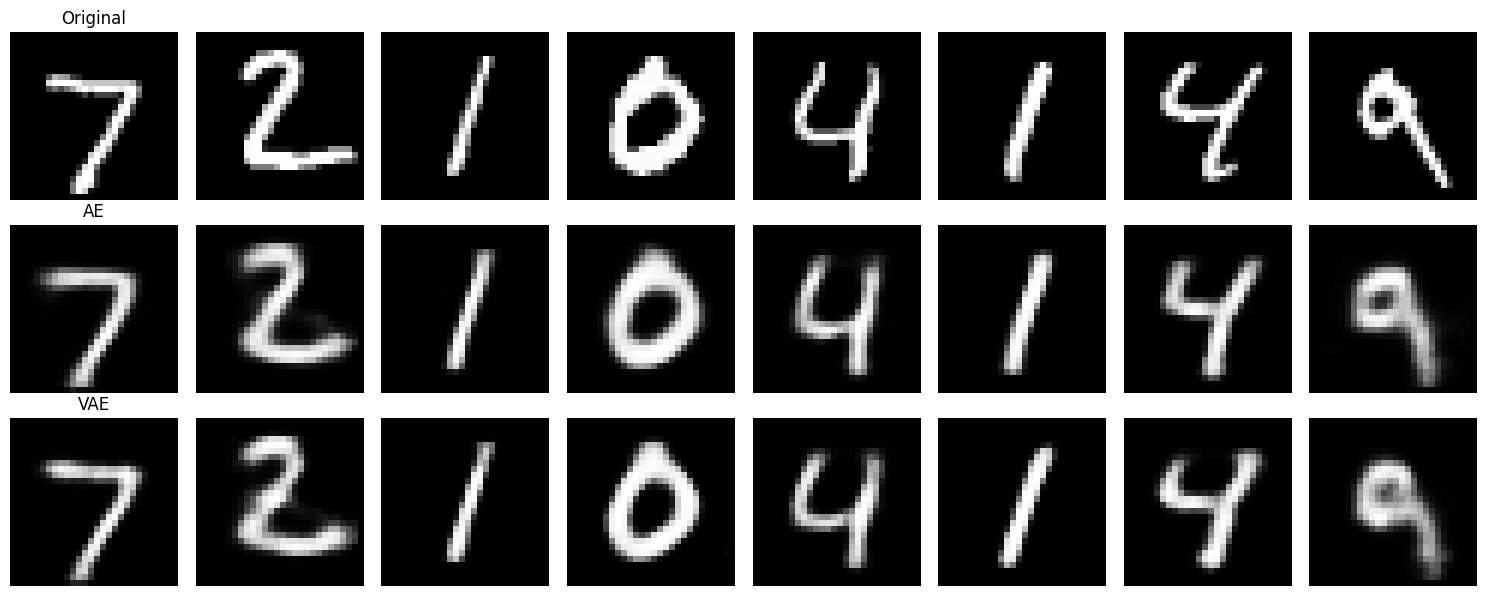

In [ ]:
with torch.no_grad():
    test_imgs, _ = next(iter(test_loader))
    test_imgs = test_imgs[:8].view(8, -1).to(device)

    ae_recon = ae_model(test_imgs)
    vae_recon, _, _ = vae_model(test_imgs)

    fig, axes = plt.subplots(3, 8, figsize=(15, 6))

    for i in range(8):
        # Original
        axes[0, i].imshow(test_imgs[i].cpu().view(28, 28), cmap='gray')
        axes[0, i].set_title('Original' if i == 0 else '')
        axes[0, i].axis('off')

        # AE reconstruction
        axes[1, i].imshow(ae_recon[i].cpu().view(28, 28), cmap='gray')
        axes[1, i].set_title('AE' if i == 0 else '')
        axes[1, i].axis('off')

        # VAE reconstruction
        axes[2, i].imshow(vae_recon[i].cpu().view(28, 28), cmap='gray')
        axes[2, i].set_title('VAE' if i == 0 else '')
        axes[2, i].axis('off')

    plt.tight_layout()
    plt.show()